# Gini vs Entropy: Understanding Impurity Measures in Classification

## Introduction

When building decision trees and other classification models, we need to measure how "impure" or "mixed" our data splits are. The two most popular measures are **Gini impurity** and **entropy**. But how do they differ in practice? This tutorial provides intuitive explanations and visual experiments to understand their fundamental differences.

## Key Takeaways

**Both measures quantify uncertainty/impurity**, but they have different sensitivities:
- **Gini impurity** is computationally faster and slightly favors larger, purer partitions
- **Entropy** is more sensitive to changes and tends to create more balanced splits
- **In practice**, the differences are often small, but understanding them helps you choose the right tool

---

## Experiment 1: Understanding Impurity - From Pure to Mixed

Let's start by understanding what "impurity" means and how each measure quantifies it.

### Mathematical Definitions

For a dataset with class probabilities p₁, p₂, ..., pₖ:

- **Gini Impurity**: `G = 1 - Σᵢ pᵢ²`
- **Entropy**: `H = -Σᵢ pᵢ log₂(pᵢ)`

### Key Insight: Different Ways to Measure "Mixedness"

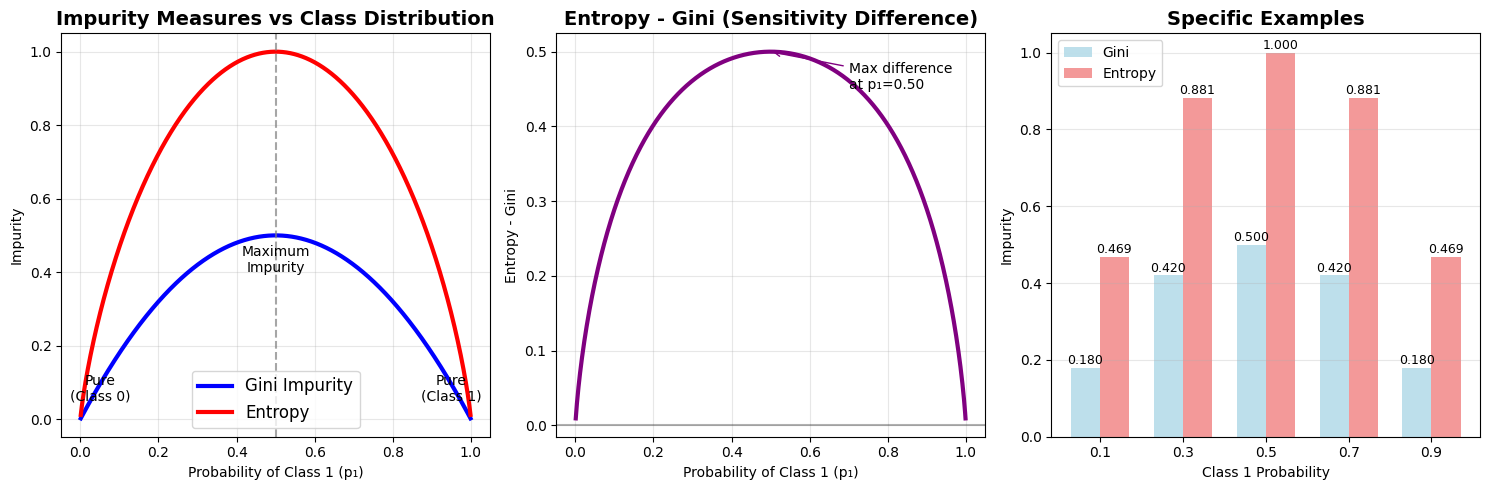

📊 KEY OBSERVATIONS:
Maximum Gini impurity: 0.500 at p₁ = 0.5
Maximum Entropy: 1.000 at p₁ = 0.5
Maximum difference (Entropy - Gini): 0.500 at p₁ = 0.500


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy as scipy_entropy

# For binary classification, vary the probability of class 1
p1_values = np.linspace(0.001, 0.999, 1000)  # Avoid exactly 0 or 1 for log
p2_values = 1 - p1_values

# Calculate impurity measures
def gini_impurity(p1, p2):
    return 1 - (p1**2 + p2**2)

def entropy_impurity(p1, p2):
    # Handle edge cases for log
    p1_safe = np.where(p1 <= 0, 1e-15, p1)
    p2_safe = np.where(p2 <= 0, 1e-15, p2)
    return -(p1_safe * np.log2(p1_safe) + p2_safe * np.log2(p2_safe))

gini_values = gini_impurity(p1_values, p2_values)
entropy_values = entropy_impurity(p1_values, p2_values)

# Create the comparison plot
plt.figure(figsize=(15, 5))

# Impurity curves
plt.subplot(1, 3, 1)
plt.plot(p1_values, gini_values, 'b-', linewidth=3, label='Gini Impurity')
plt.plot(p1_values, entropy_values, 'r-', linewidth=3, label='Entropy')
plt.title('Impurity Measures vs Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Probability of Class 1 (p₁)')
plt.ylabel('Impurity')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Mark key points
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.7, label='Maximum impurity')
plt.annotate('Pure\n(Class 0)', xy=(0.05, 0.05), fontsize=10, ha='center')
plt.annotate('Maximum\nImpurity', xy=(0.5, 0.4), fontsize=10, ha='center')
plt.annotate('Pure\n(Class 1)', xy=(0.95, 0.05), fontsize=10, ha='center')

# Difference between measures
plt.subplot(1, 3, 2)
difference = entropy_values - gini_values
plt.plot(p1_values, difference, 'purple', linewidth=3)
plt.title('Entropy - Gini (Sensitivity Difference)', fontsize=14, fontweight='bold')
plt.xlabel('Probability of Class 1 (p₁)')
plt.ylabel('Entropy - Gini')
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linestyle='-', alpha=0.3)

max_diff_idx = np.argmax(difference)
max_diff_p = p1_values[max_diff_idx]
max_diff_val = difference[max_diff_idx]
plt.annotate(f'Max difference\nat p₁={max_diff_p:.2f}', 
            xy=(max_diff_p, max_diff_val), xytext=(0.7, max_diff_val-0.05),
            arrowprops=dict(arrowstyle='->', color='purple'), fontsize=10)

# Demonstrate with specific examples
plt.subplot(1, 3, 3)
example_probs = [0.1, 0.3, 0.5, 0.7, 0.9]
example_gini = [gini_impurity(p, 1-p) for p in example_probs]
example_entropy = [entropy_impurity(p, 1-p) for p in example_probs]

x_pos = np.arange(len(example_probs))
width = 0.35

plt.bar(x_pos - width/2, example_gini, width, label='Gini', color='lightblue', alpha=0.8)
plt.bar(x_pos + width/2, example_entropy, width, label='Entropy', color='lightcoral', alpha=0.8)

plt.title('Specific Examples', fontsize=14, fontweight='bold')
plt.xlabel('Class 1 Probability')
plt.ylabel('Impurity')
plt.xticks(x_pos, [f'{p:.1f}' for p in example_probs])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (g, e) in enumerate(zip(example_gini, example_entropy)):
    plt.text(i - width/2, g + 0.01, f'{g:.3f}', ha='center', fontsize=9)
    plt.text(i + width/2, e + 0.01, f'{e:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("📊 KEY OBSERVATIONS:")
print(f"Maximum Gini impurity: {max(gini_values):.3f} at p₁ = 0.5")
print(f"Maximum Entropy: {max(entropy_values):.3f} at p₁ = 0.5")
print(f"Maximum difference (Entropy - Gini): {max_diff_val:.3f} at p₁ = {max_diff_p:.3f}")

### What This Reveals

1. **Both measures peak at 50-50 splits** - maximum uncertainty
2. **Both reach zero for pure splits** - no uncertainty
3. **Entropy is always ≥ Gini** - it's more sensitive to impurity
4. **The difference is largest** around 70-30 splits, not at maximum impurity

---

## Experiment 2: Multi-Class Behavior - Beyond Binary

Let's see how these measures behave with multiple classes, which reveals more subtle differences.

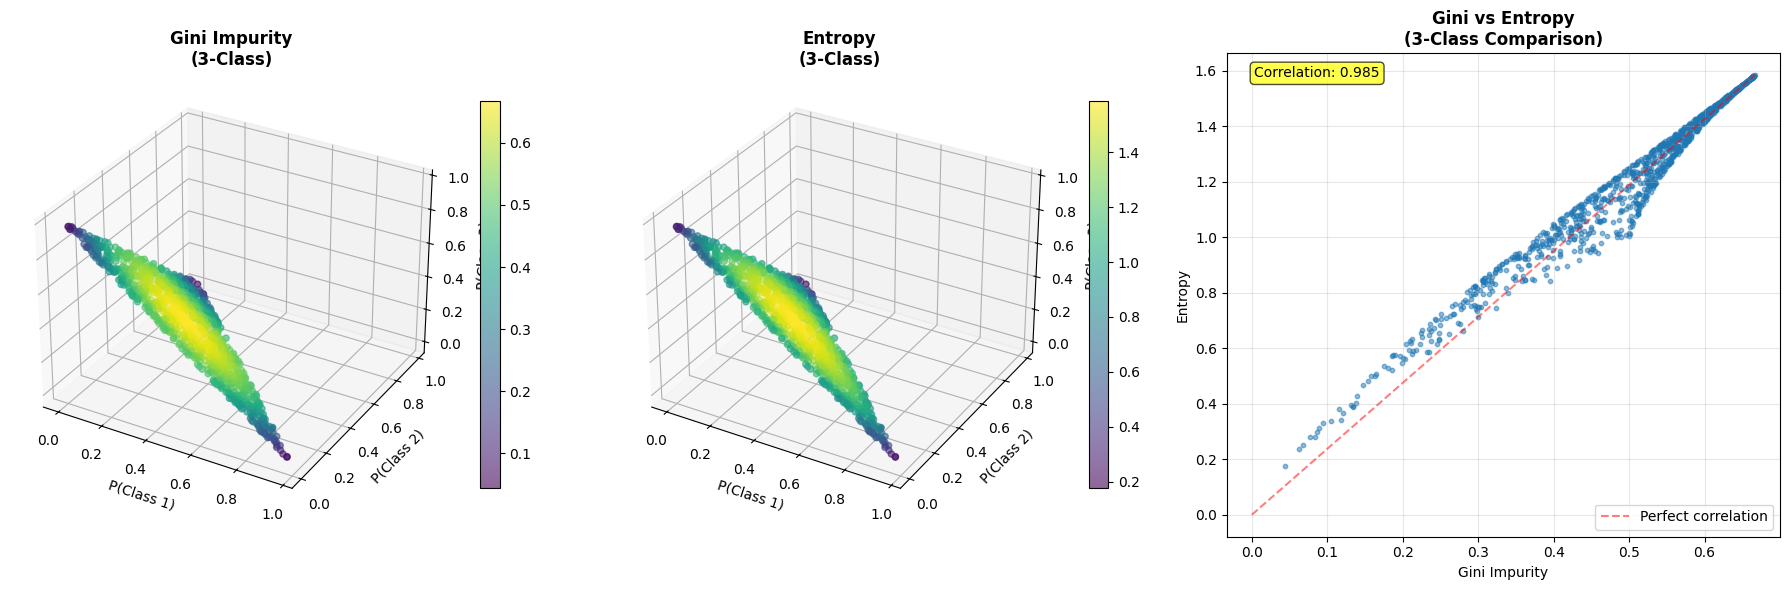


🎯 MULTI-CLASS SCENARIOS:
Scenario               | Gini   | Entropy | Ratio (H/G)
-------------------------------------------------------
Pure (1,0,0)         | 0.000 | 0.000  | inf
Uniform (1/3,1/3,1/3) | 0.667 | 1.585  | 2.377
Binary-like (0.5,0.5,0) | 0.500 | 1.000  | 2.000
Skewed (0.7,0.2,0.1) | 0.460 | 1.157  | 2.515
Two dominant (0.4,0.4,0.2) | 0.640 | 1.522  | 2.378


In [2]:
from itertools import combinations_with_replacement
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate all possible probability distributions for 3 classes
# We'll sample uniformly from the probability simplex
np.random.seed(42)
n_samples = 1000

# Generate random points in 3D probability simplex
random_points = np.random.dirichlet([1, 1, 1], n_samples)
p1, p2, p3 = random_points[:, 0], random_points[:, 1], random_points[:, 2]

# Calculate impurity measures for 3-class case
def gini_multiclass(probs):
    return 1 - np.sum(probs**2, axis=1)

def entropy_multiclass(probs):
    # Avoid log(0) by adding small epsilon
    probs_safe = np.where(probs <= 0, 1e-15, probs)
    return -np.sum(probs_safe * np.log2(probs_safe), axis=1)

gini_multi = gini_multiclass(random_points)
entropy_multi = entropy_multiclass(random_points)

# Create visualization
fig = plt.figure(figsize=(18, 6))

# 3D scatter plot of impurity measures
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(p1, p2, p3, c=gini_multi, cmap='viridis', alpha=0.6)
ax1.set_xlabel('P(Class 1)')
ax1.set_ylabel('P(Class 2)')
ax1.set_zlabel('P(Class 3)')
ax1.set_title('Gini Impurity\n(3-Class)', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax1, shrink=0.8)

ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(p1, p2, p3, c=entropy_multi, cmap='viridis', alpha=0.6)
ax2.set_xlabel('P(Class 1)')
ax2.set_ylabel('P(Class 2)')
ax2.set_zlabel('P(Class 3)')
ax2.set_title('Entropy\n(3-Class)', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, shrink=0.8)

# Direct comparison
ax3 = fig.add_subplot(133)
ax3.scatter(gini_multi, entropy_multi, alpha=0.5, s=10)
ax3.set_xlabel('Gini Impurity')
ax3.set_ylabel('Entropy')
ax3.set_title('Gini vs Entropy\n(3-Class Comparison)', fontsize=12, fontweight='bold')
ax3.plot([0, max(gini_multi)], [0, max(entropy_multi)], 'r--', alpha=0.5, label='Perfect correlation')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Add correlation coefficient
correlation = np.corrcoef(gini_multi, entropy_multi)[0, 1]
ax3.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax3.transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

# Analyze specific multi-class scenarios
scenarios = {
    'Pure (1,0,0)': [1.0, 0.0, 0.0],
    'Uniform (1/3,1/3,1/3)': [1/3, 1/3, 1/3],
    'Binary-like (0.5,0.5,0)': [0.5, 0.5, 0.0],
    'Skewed (0.7,0.2,0.1)': [0.7, 0.2, 0.1],
    'Two dominant (0.4,0.4,0.2)': [0.4, 0.4, 0.2]
}

print("\n🎯 MULTI-CLASS SCENARIOS:")
print("Scenario               | Gini   | Entropy | Ratio (H/G)")
print("-" * 55)
for name, probs in scenarios.items():
    probs_array = np.array([probs])
    g = gini_multiclass(probs_array)[0]
    h = entropy_multiclass(probs_array)[0]
    ratio = h/g if g > 0 else float('inf')
    print(f"{name:20} | {g:.3f} | {h:.3f}  | {ratio:.3f}")

### Multi-Class Insights

1. **High correlation but not identical** - both capture similar information
2. **Entropy is consistently higher** - more sensitive to all sources of impurity  
3. **The ratio H/G varies** - depends on the distribution shape
4. **Uniform distribution** gives maximum impurity for both measures

---

## Experiment 3: Decision Tree Splitting - Where the Rubber Meets the Road

Now let's see how these measures actually guide decision tree splits in practice.

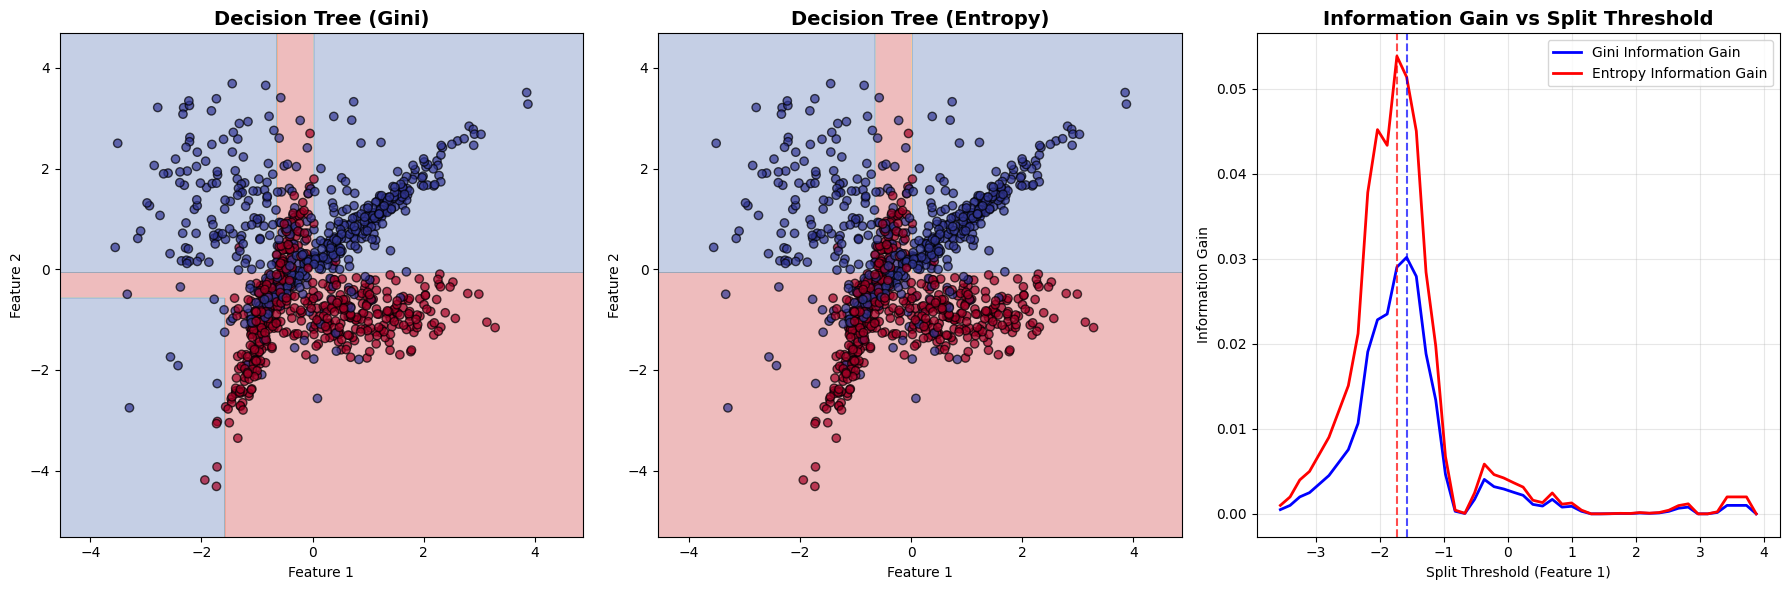

🌳 DECISION TREE COMPARISON:
Gini Tree - Depth: 3, Leaves: 8
Entropy Tree - Depth: 3, Leaves: 8
Gini Tree - Training Accuracy: 0.839
Entropy Tree - Training Accuracy: 0.837

Best split thresholds:
Gini: -1.581 (gain: 0.030)
Entropy: -1.733 (gain: 0.054)


In [3]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# Create a synthetic dataset with clear patterns
np.random.seed(42)
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                          n_informative=2, n_clusters_per_class=2, 
                          class_sep=0.8, random_state=42)

# Add some noise to make it interesting
X += np.random.normal(0, 0.1, X.shape)

# Function to calculate information gain for a split
def calculate_information_gain(parent_labels, left_labels, right_labels, criterion='gini'):
    def impurity(labels):
        if len(labels) == 0:
            return 0
        proportions = np.bincount(labels) / len(labels)
        if criterion == 'gini':
            return 1 - np.sum(proportions**2)
        else:  # entropy
            proportions = proportions[proportions > 0]  # Remove zeros for log
            return -np.sum(proportions * np.log2(proportions))
    
    n_parent = len(parent_labels)
    n_left, n_right = len(left_labels), len(right_labels)
    
    if n_parent == 0:
        return 0
    
    parent_impurity = impurity(parent_labels)
    weighted_child_impurity = (n_left/n_parent * impurity(left_labels) + 
                              n_right/n_parent * impurity(right_labels))
    
    return parent_impurity - weighted_child_impurity

# Create decision trees with different criteria
dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

dt_gini.fit(X, y)
dt_entropy.fit(X, y)

# Visualize the decision boundaries
plt.figure(figsize=(18, 6))

def plot_decision_boundary(ax, clf, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black', alpha=0.7)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    return scatter

# Plot decision boundaries
ax1 = plt.subplot(131)
scatter1 = plot_decision_boundary(ax1, dt_gini, X, y, 'Decision Tree (Gini)')

ax2 = plt.subplot(132)
scatter2 = plot_decision_boundary(ax2, dt_entropy, X, y, 'Decision Tree (Entropy)')

# Compare split thresholds and information gains
ax3 = plt.subplot(133)

# Simulate some potential splits and show information gain
feature_idx = 0  # Split on first feature
thresholds = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), 50)
gini_gains = []
entropy_gains = []

for threshold in thresholds:
    left_mask = X[:, feature_idx] <= threshold
    right_mask = ~left_mask
    
    gini_gain = calculate_information_gain(y, y[left_mask], y[right_mask], 'gini')
    entropy_gain = calculate_information_gain(y, y[left_mask], y[right_mask], 'entropy')
    
    gini_gains.append(gini_gain)
    entropy_gains.append(entropy_gain)

ax3.plot(thresholds, gini_gains, 'b-', linewidth=2, label='Gini Information Gain')
ax3.plot(thresholds, entropy_gains, 'r-', linewidth=2, label='Entropy Information Gain')
ax3.set_title('Information Gain vs Split Threshold', fontsize=14, fontweight='bold')
ax3.set_xlabel('Split Threshold (Feature 1)')
ax3.set_ylabel('Information Gain')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Mark the best splits
best_gini_idx = np.argmax(gini_gains)
best_entropy_idx = np.argmax(entropy_gains)
ax3.axvline(thresholds[best_gini_idx], color='blue', linestyle='--', alpha=0.7)
ax3.axvline(thresholds[best_entropy_idx], color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Compare tree statistics
print("🌳 DECISION TREE COMPARISON:")
print(f"Gini Tree - Depth: {dt_gini.get_depth()}, Leaves: {dt_gini.get_n_leaves()}")
print(f"Entropy Tree - Depth: {dt_entropy.get_depth()}, Leaves: {dt_entropy.get_n_leaves()}")
print(f"Gini Tree - Training Accuracy: {dt_gini.score(X, y):.3f}")
print(f"Entropy Tree - Training Accuracy: {dt_entropy.score(X, y):.3f}")

# Show the actual best splits found
print(f"\nBest split thresholds:")
print(f"Gini: {thresholds[best_gini_idx]:.3f} (gain: {gini_gains[best_gini_idx]:.3f})")
print(f"Entropy: {thresholds[best_entropy_idx]:.3f} (gain: {entropy_gains[best_entropy_idx]:.3f})")

### Decision Tree Insights

1. **Both often produce similar trees** but may choose different splits
2. **Information gain curves are highly correlated** but peaks may differ
3. **Gini is computationally faster** - no logarithms to compute
4. **Entropy may create more balanced splits** in some scenarios

---

## Experiment 4: Computational Performance and Sensitivity Analysis

Let's quantify the practical differences in computation and sensitivity.

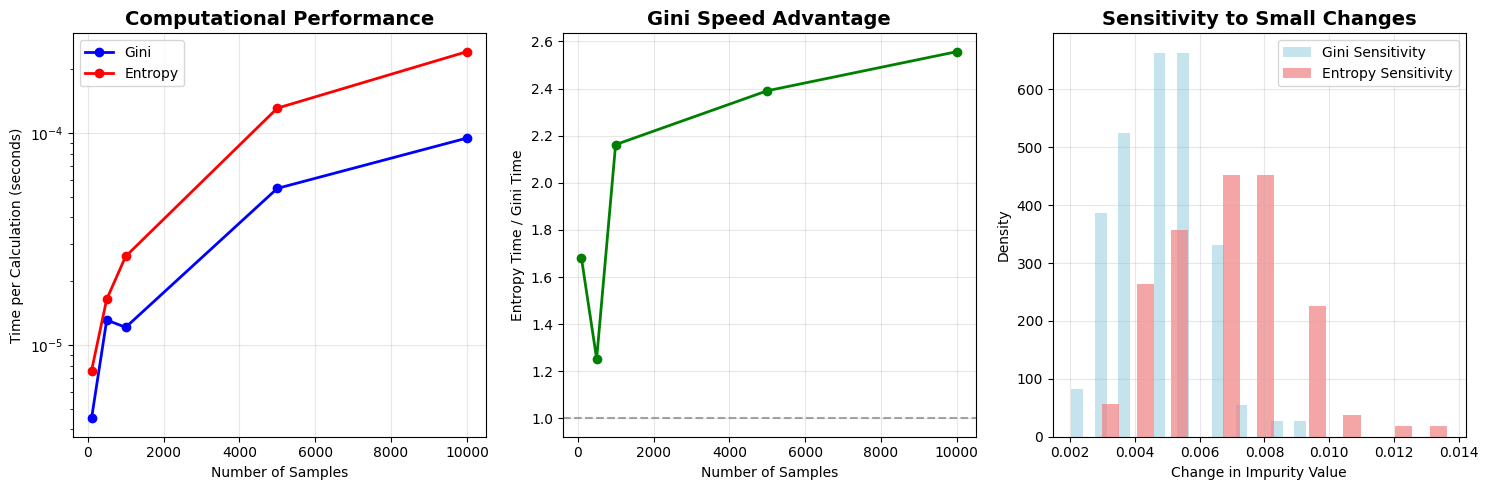

⚡ PERFORMANCE ANALYSIS:
Average speedup factor (Entropy/Gini time): 2.01x
Gini is 2.0x faster on average

📊 SENSITIVITY ANALYSIS:
Average Gini sensitivity: 0.0047
Average Entropy sensitivity: 0.0069
Entropy is 1.5x more sensitive to changes


In [4]:
import time
from sklearn.datasets import make_classification

# Performance comparison
def benchmark_impurity_calculations(n_samples_list, n_classes=2):
    gini_times = []
    entropy_times = []
    
    for n_samples in n_samples_list:
        # Generate random class probabilities
        np.random.seed(42)
        probs = np.random.dirichlet([1]*n_classes, n_samples)
        
        # Time Gini calculation
        start_time = time.time()
        for _ in range(100):  # Average over multiple runs
            gini_vals = 1 - np.sum(probs**2, axis=1)
        gini_time = (time.time() - start_time) / 100
        gini_times.append(gini_time)
        
        # Time Entropy calculation
        start_time = time.time()
        for _ in range(100):
            probs_safe = np.where(probs <= 0, 1e-15, probs)
            entropy_vals = -np.sum(probs_safe * np.log2(probs_safe), axis=1)
        entropy_time = (time.time() - start_time) / 100
        entropy_times.append(entropy_time)
    
    return gini_times, entropy_times

# Run benchmark
sample_sizes = [100, 500, 1000, 5000, 10000]
gini_times, entropy_times = benchmark_impurity_calculations(sample_sizes)

# Sensitivity analysis - how much do splits change with small data changes?
def sensitivity_analysis():
    np.random.seed(42)
    original_data = np.random.choice([0, 1], size=1000, p=[0.6, 0.4])
    
    # Create 100 slightly perturbed versions
    n_perturbations = 100
    gini_changes = []
    entropy_changes = []
    
    original_gini = gini_impurity(0.6, 0.4)
    original_entropy = entropy_impurity(0.6, 0.4)
    
    for _ in range(n_perturbations):
        # Randomly flip 1% of the labels
        perturbed_data = original_data.copy()
        flip_indices = np.random.choice(len(original_data), size=int(0.01*len(original_data)), replace=False)
        perturbed_data[flip_indices] = 1 - perturbed_data[flip_indices]
        
        p1_new = np.mean(perturbed_data)
        p2_new = 1 - p1_new
        
        new_gini = gini_impurity(p1_new, p2_new)
        new_entropy = entropy_impurity(p1_new, p2_new)
        
        gini_changes.append(abs(new_gini - original_gini))
        entropy_changes.append(abs(new_entropy - original_entropy))
    
    return gini_changes, entropy_changes

gini_sensitivity, entropy_sensitivity = sensitivity_analysis()

# Create comparison plots
plt.figure(figsize=(15, 5))

# Performance comparison
plt.subplot(131)
plt.plot(sample_sizes, gini_times, 'b-o', linewidth=2, label='Gini')
plt.plot(sample_sizes, entropy_times, 'r-o', linewidth=2, label='Entropy')
plt.title('Computational Performance', fontsize=14, fontweight='bold')
plt.xlabel('Number of Samples')
plt.ylabel('Time per Calculation (seconds)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Speedup factor
speedup_factors = np.array(entropy_times) / np.array(gini_times)
plt.subplot(132)
plt.plot(sample_sizes, speedup_factors, 'g-o', linewidth=2)
plt.title('Gini Speed Advantage', fontsize=14, fontweight='bold')
plt.xlabel('Number of Samples')
plt.ylabel('Entropy Time / Gini Time')
plt.grid(True, alpha=0.3)
plt.axhline(y=1, color='gray', linestyle='--', alpha=0.7)

# Sensitivity comparison
plt.subplot(133)
plt.hist(gini_sensitivity, bins=20, alpha=0.7, label='Gini Sensitivity', color='lightblue', density=True)
plt.hist(entropy_sensitivity, bins=20, alpha=0.7, label='Entropy Sensitivity', color='lightcoral', density=True)
plt.title('Sensitivity to Small Changes', fontsize=14, fontweight='bold')
plt.xlabel('Change in Impurity Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("⚡ PERFORMANCE ANALYSIS:")
print(f"Average speedup factor (Entropy/Gini time): {np.mean(speedup_factors):.2f}x")
print(f"Gini is {np.mean(speedup_factors):.1f}x faster on average")

print(f"\n📊 SENSITIVITY ANALYSIS:")
print(f"Average Gini sensitivity: {np.mean(gini_sensitivity):.4f}")
print(f"Average Entropy sensitivity: {np.mean(entropy_sensitivity):.4f}")
print(f"Entropy is {np.mean(entropy_sensitivity)/np.mean(gini_sensitivity):.1f}x more sensitive to changes")

---

## Practical Decision Guide

### When to Use Gini Impurity
✅ **Choose Gini when:**
- **Speed matters** - up to 2-3x faster computation
- You have **large datasets** where performance is critical
- You want **slightly more balanced trees** 
- Working with **binary classification**
- **Default choice** for most applications

### When to Use Entropy
✅ **Choose Entropy when:**
- You need **maximum sensitivity** to impurity changes
- Working with **multi-class problems** (>2 classes)
- **Theoretical interpretability** matters (information theory)
- You want to **maximize information gain**
- Fine-tuning is critical and speed is not a constraint

### Real-World Applications

**Gini is preferred for:**
- Web-scale applications (search, recommendation)
- Real-time decision systems
- Mobile/edge computing
- Business intelligence dashboards

**Entropy is preferred for:**
- Scientific research and analysis
- Medical diagnosis systems
- Natural language processing
- When theoretical justification is needed

---

## Mathematical Intuition Summary

### Shape Differences
- **Gini**: Quadratic penalty `(1 - Σpᵢ²)` - favors splits that create purer large partitions
- **Entropy**: Logarithmic penalty `(-Σpᵢlog₂pᵢ)` - more sensitive to all probability changes

### Information Theory Connection
- **Entropy** directly measures "bits of information" needed to describe the distribution
- **Gini** can be interpreted as the probability of misclassifying a randomly chosen element

### Optimization Behavior
- Both are **concave functions** - single optimum for any split
- **Entropy** has **higher curvature** - more sensitive to probability changes
- **Gini** is **smoother** - may be more robust to noise

---

## Key Takeaways

1. **Both measures capture the same concept** (impurity/uncertainty) but with different sensitivities
2. **Gini is faster and often sufficient** for most practical applications
3. **Entropy is more theoretically grounded** and sensitive to distributional changes
4. **In practice, differences are often minimal** - choose based on computational constraints
5. **Multi-class scenarios** may show more pronounced differences between the measures

The choice between Gini and Entropy is often less critical than other hyperparameters like tree depth, minimum samples per leaf, or feature selection. Start with Gini for speed, switch to Entropy if you need maximum sensitivity!